In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import statistics 
import math


In [6]:
!pip install st-dbscan
from st_dbscan import ST_DBSCAN
!pip install geopy
import geopy.distance

In [7]:
df_fix = pd.read_csv("C:/Users/t480/Desktop/University courses/ENSAE 2A/STATAPP/Statapp-Hail-storm/bdd.csv")

In [8]:
def convert_time_to_timestamps(df):
    df['TIME_EVENT'] = pd.to_datetime(df['TIME_EVENT'],format = '%Y-%m-%d %H:%M:%S')
    df['TIME_EVENT'] = df.TIME_EVENT.values.astype(np.float64) # in nanoseconds
    df.TIME_EVENT = df.TIME_EVENT / (10 ** 9) # in seconds 
    df.TIME_EVENT = df.TIME_EVENT / 3600 # in hours
    return df

In [18]:
def getting_ready(df, country, year_since):
    df = convert_time_to_timestamps(df)
    df = df[df['COUNTRY'] == country]
    df = df[df['YEAR'] >= year_since]
    df = df[['TIME_EVENT', 'LATITUDE', 'LONGITUDE']]
    df = df.reset_index(drop=True)
    return df 

In [10]:
def run_dbscan_retrieve_classes(df, spatial_th, time_th, min_sample):
    model = ST_DBSCAN(eps1=spatial_th, eps2=time_th, min_samples=min_sample)
    fit = model.fit(df) 
    labels = pd.DataFrame(model.labels)
    df['LABELS'] = labels
    return df

Visualising the timing of reports with an intensity map 

In [111]:
def visualise_biggest(df, n_biggest):

    nb_reports = pd.DataFrame(df['LABELS'].value_counts()).reset_index()
    nb_reports = nb_reports[nb_reports['index'] != -1].sort_values('LABELS', ascending=False).reset_index()
    labels_biggest_storms = list(nb_reports.iloc[0:3,1])
    df_biggest = df.loc[df.LABELS.isin(labels_biggest_storms)]

    # plots the n_biggest storms 
    plt.figure(figsize=(10,6))
    for i in range(n_biggest):
        a = df_biggest.LONGITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        b = df_biggest.LATITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        lab = df_biggest.loc[df_biggest.LABELS == labels_biggest_storms[i]]
        plt.scatter(a, b, c='C{}'.format(i), label='{} most reported storm'.format(i+1))
    plt.ylabel('latitude')
    plt.xlabel('longitude')
    plt.legend()
    plt.title("The {} biggest storms in terms of report counts".format(len(labels_biggest_storms)))
    plt.show()

    # plot timing of storms in latlon
    for i in range(n_biggest):
        x = df_biggest.LONGITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        y = df_biggest.LATITUDE[df_biggest.LABELS == labels_biggest_storms[i]]
        z = df_biggest.TIME_EVENT[df_biggest.LABELS == labels_biggest_storms[i]]
        z = z - z.iloc[-1]
        x = x.array
        y = y.array
        z = z.array
        axis = plt.subplot(111, title="Storm with {} reports".format(len(x)))
        sc = axis.scatter(x, y, c=z, marker=".")
        plt.colorbar(sc, label="duration of the storm (in hours)")
        plt.show()
        # distance between first and last reports
        df_distance = df_biggest[df_biggest.LABELS==labels_biggest_storms[i]].sort_values('TIME_EVENT')
        df_distance = df_distance.reset_index(drop=True)
        latbegin = df_distance.LATITUDE[0]
        latend = df_distance.LATITUDE[len(df_distance.LATITUDE)-1]
        lonbegin = df_distance.LONGITUDE[0]
        lonend = df_distance.LONGITUDE[len(df_distance.LONGITUDE)-1]
        coords_1 = (latbegin, lonbegin)
        coords_2 = (latend, lonend)
        dist = geopy.distance.geodesic(coords_1, coords_2).km
        print("The storm has length",dist,"km between first report and last report")


    return df

In [171]:
df = df_fix.copy()
country = 'FR'
year_since = 2022
df = getting_ready(df, country, year_since)
df

,TIME_EVENT,LATITUDE,LONGITUDE
0,462946.250000,45.567,5.933
1,462945.866667,45.596,5.875
2,462928.500000,49.583,1.358
3,462928.416667,49.533,1.267
4,462928.383333,49.521,1.251
...,...,...,...
1975,458531.666667,43.279,2.460
1976,458514.500000,44.600,-0.933
1977,458174.283333,48.669,5.114
1978,458174.166667,48.636,4.952


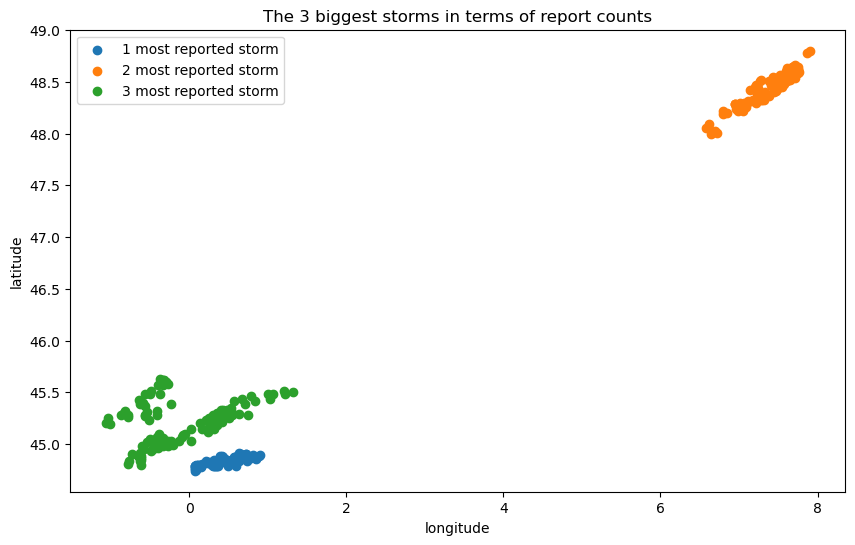

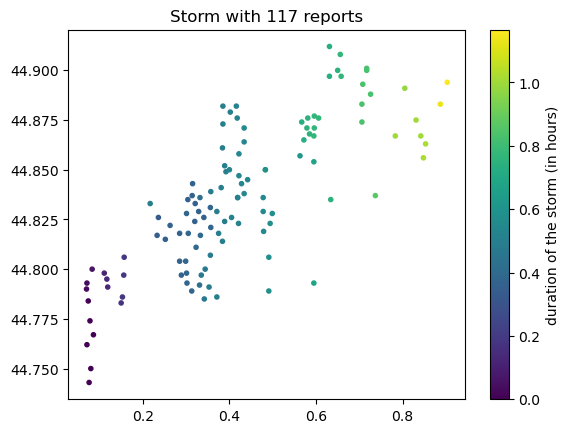

The storm has length 67.52959590342745 km between first report and last report


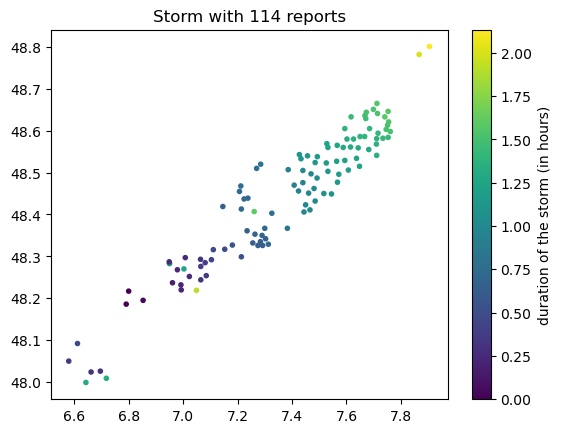

The storm has length 104.32207762462274 km between first report and last report


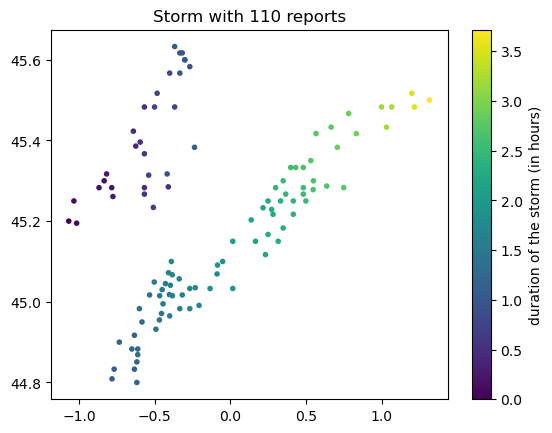

The storm has length 189.76721988809064 km between first report and last report


,TIME_EVENT,LATITUDE,LONGITUDE,LABELS
0,462946.250000,45.567,5.933,0
1,462945.866667,45.596,5.875,0
2,462928.500000,49.583,1.358,1
3,462928.416667,49.533,1.267,1
4,462928.383333,49.521,1.251,1
...,...,...,...,...
1975,458531.666667,43.279,2.460,170
1976,458514.500000,44.600,-0.933,-1
1977,458174.283333,48.669,5.114,171
1978,458174.166667,48.636,4.952,171


In [177]:
df1 = run_dbscan_retrieve_classes(df, 0.2, 2, 2)
visualise_biggest(df1,3)

Inspecting information gains from changing parameters 

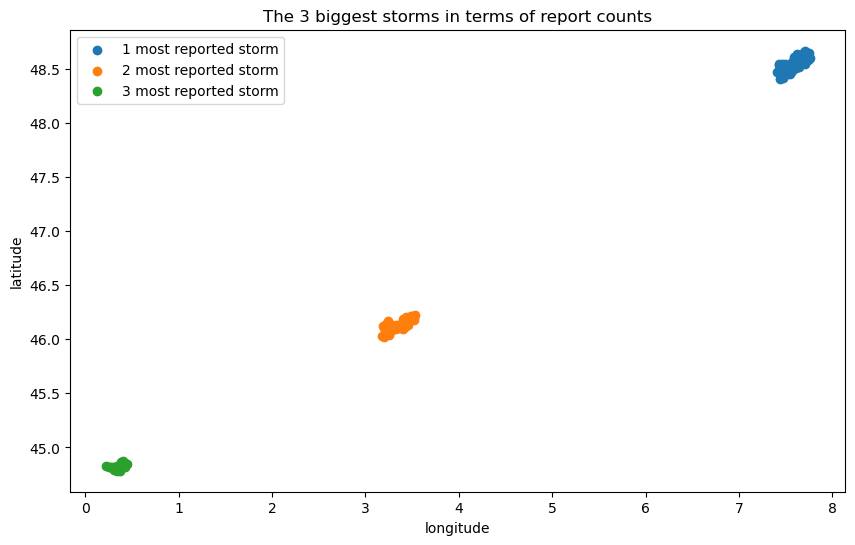

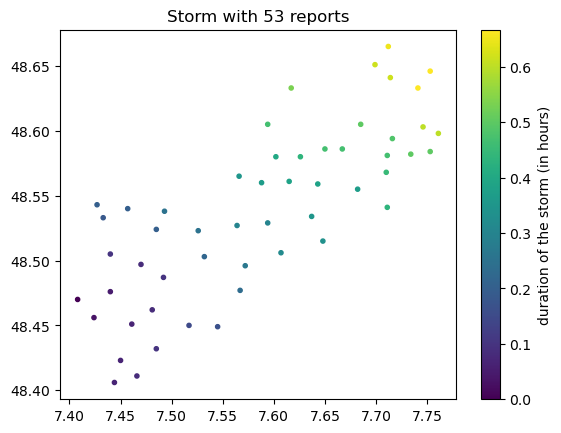

The storm has length 30.543821465197105 km between first report and last report


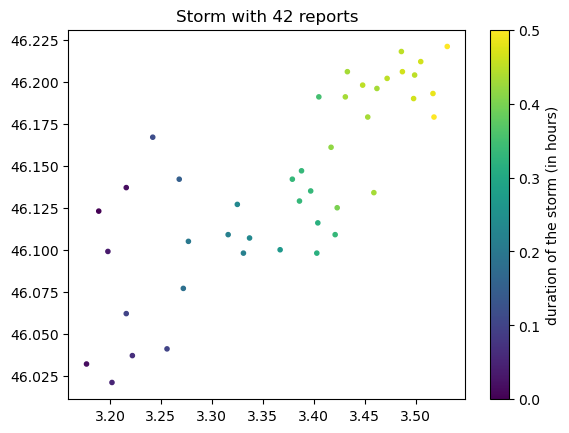

The storm has length 26.167127242818413 km between first report and last report


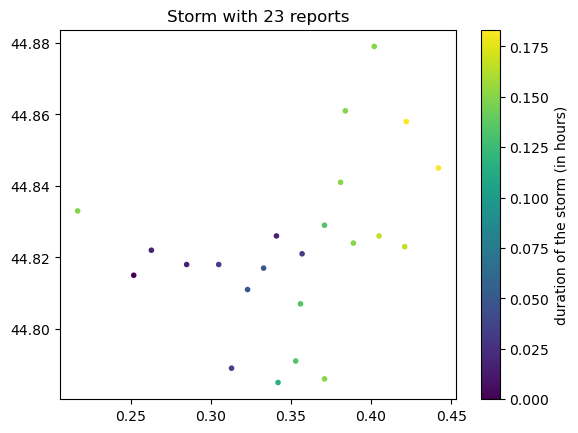

The storm has length 15.390550784301073 km between first report and last report


,TIME_EVENT,LATITUDE,LONGITUDE,LABELS
0,462946.250000,45.567,5.933,0
1,462945.866667,45.596,5.875,0
2,462928.500000,49.583,1.358,-1
3,462928.416667,49.533,1.267,1
4,462928.383333,49.521,1.251,1
...,...,...,...,...
1975,458531.666667,43.279,2.460,529
1976,458514.500000,44.600,-0.933,-1
1977,458174.283333,48.669,5.114,-1
1978,458174.166667,48.636,4.952,-1


In [188]:
#best guess
visualise_biggest(run_dbscan_retrieve_classes(df, 0.15, 1, 2),3)

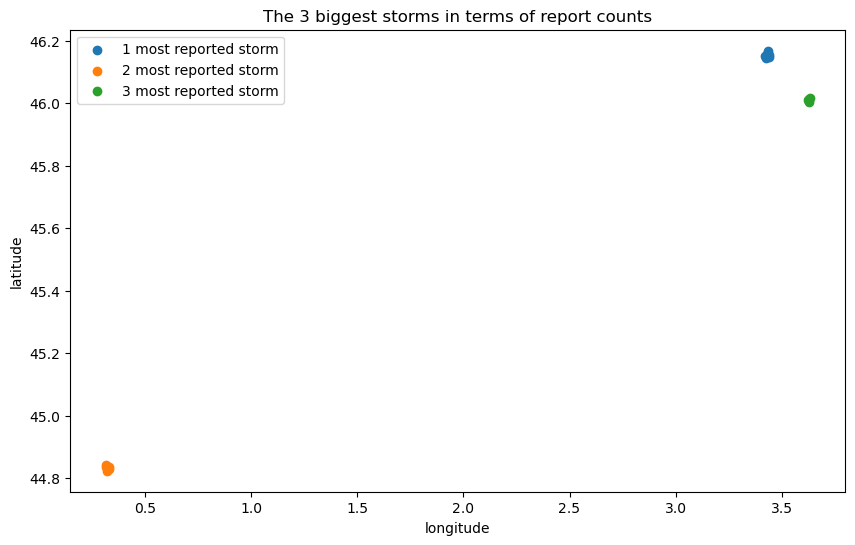

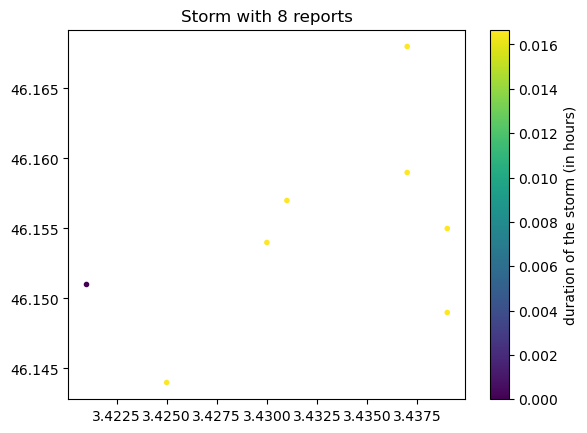

The storm has length 2.257875333103289 km between first report and last report


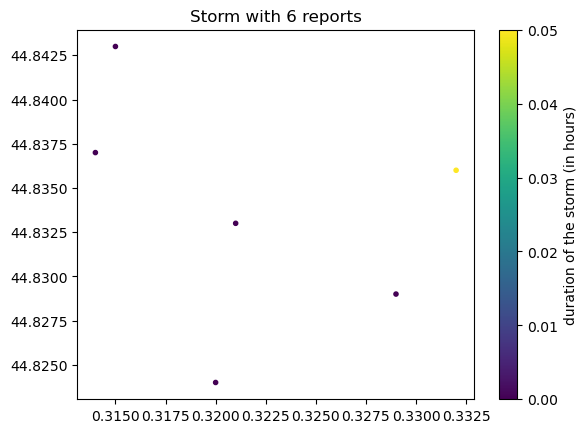

The storm has length 1.5530044688576652 km between first report and last report


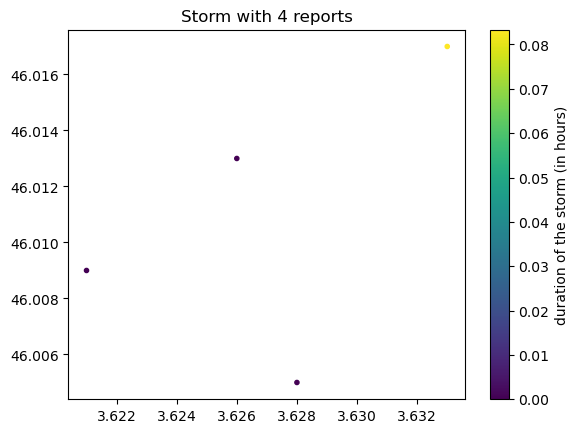

The storm has length 1.286225218985935 km between first report and last report
Spatial threshold is 0.01


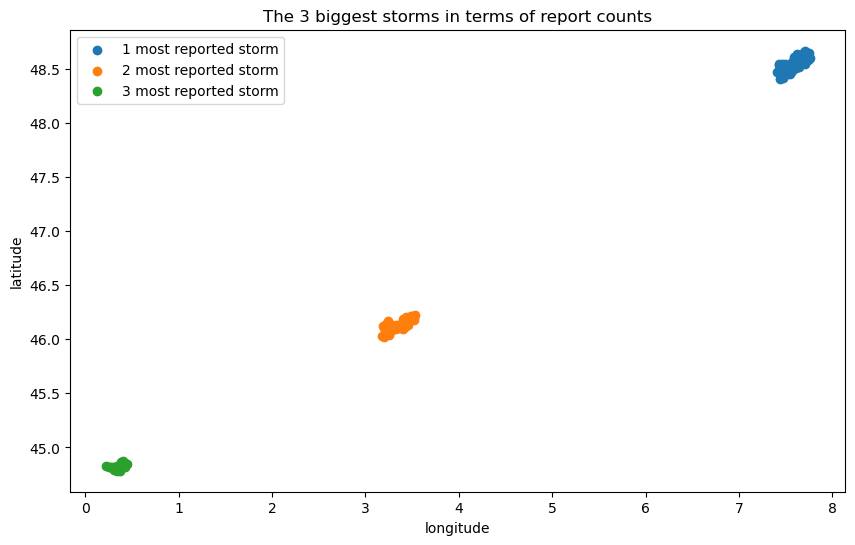

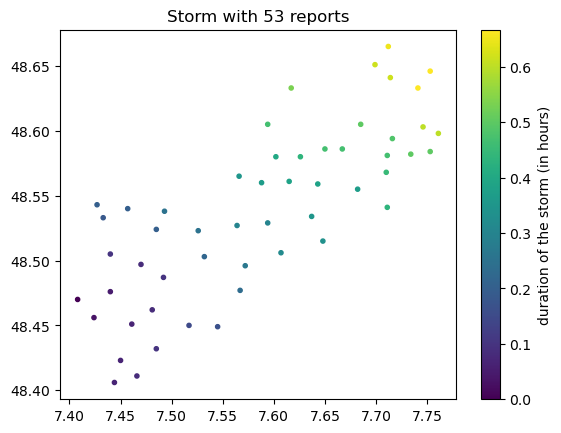

The storm has length 30.543821465197105 km between first report and last report


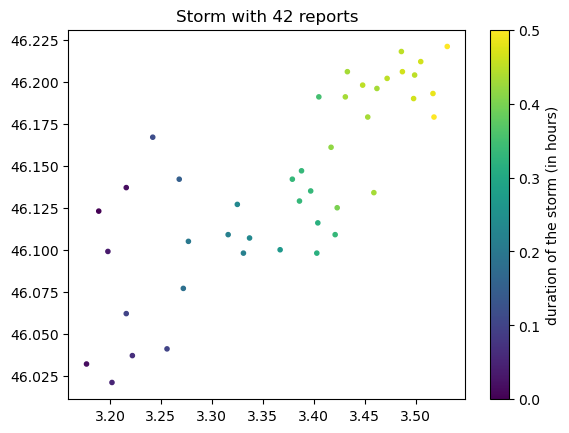

The storm has length 26.167127242818413 km between first report and last report


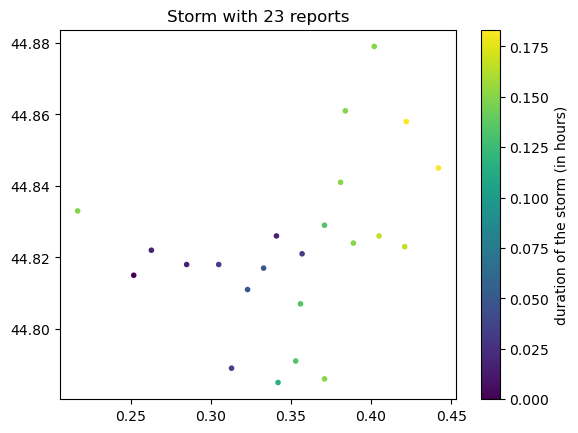

The storm has length 15.390550784301073 km between first report and last report
Spatial threshold is 0.04


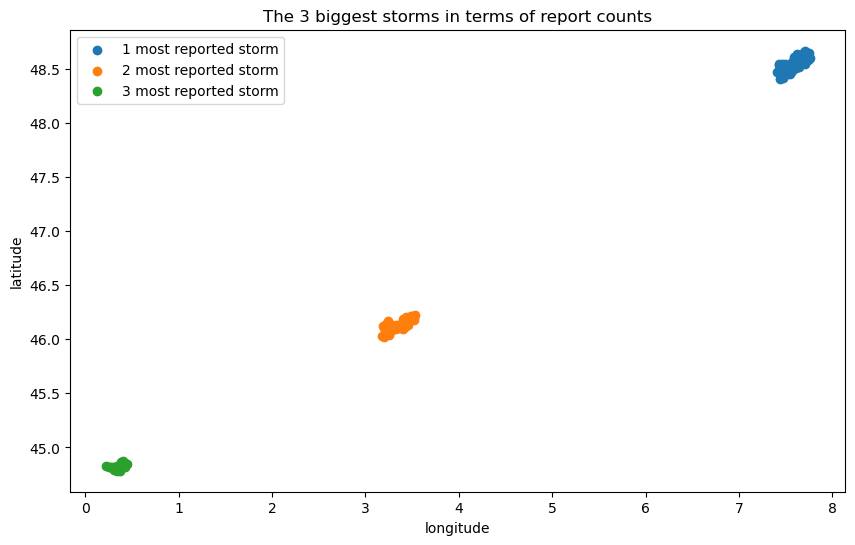

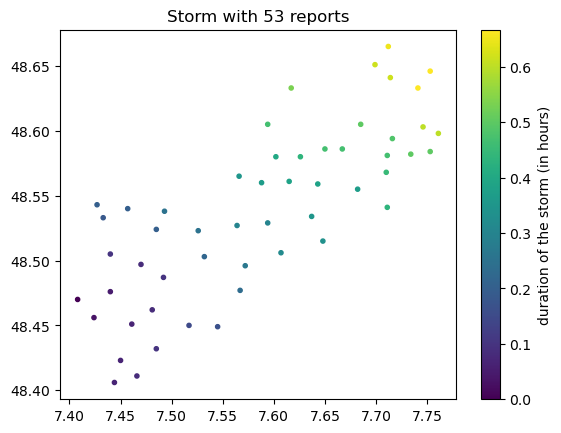

The storm has length 30.543821465197105 km between first report and last report


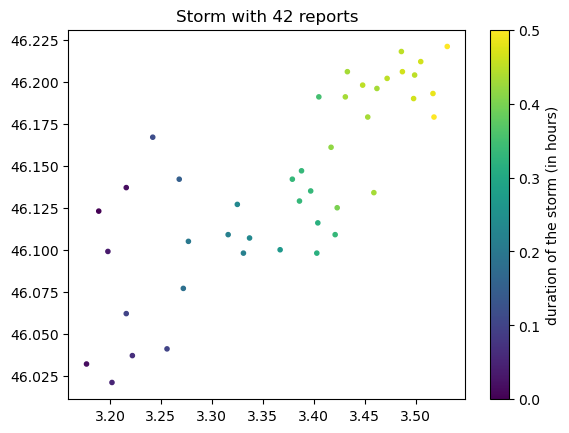

The storm has length 26.167127242818413 km between first report and last report


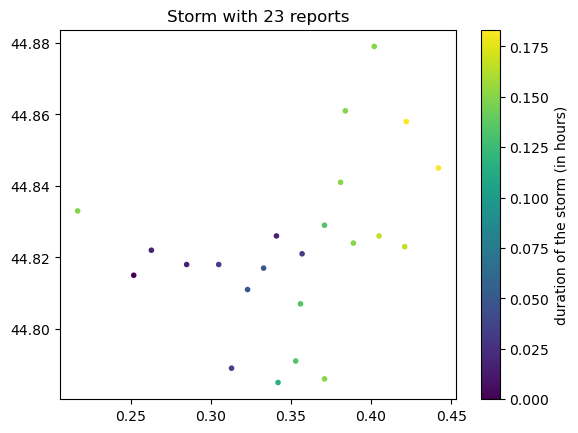

The storm has length 15.390550784301073 km between first report and last report
Spatial threshold is 0.06999999999999999


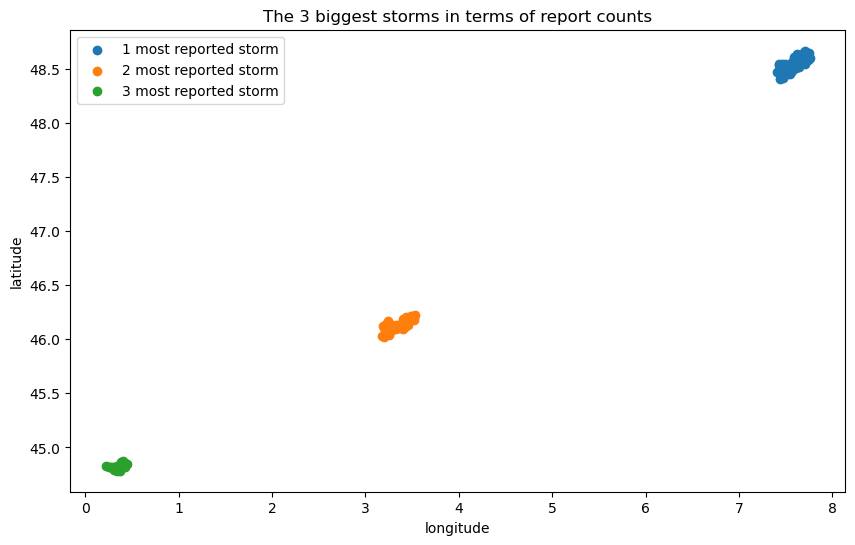

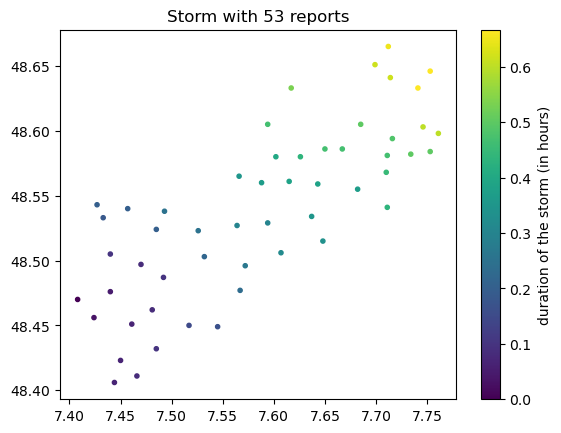

The storm has length 30.543821465197105 km between first report and last report


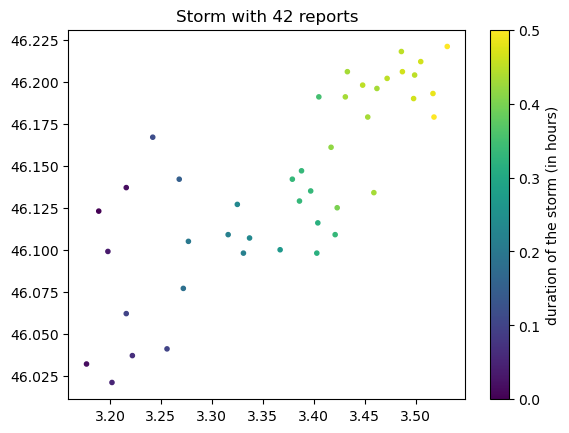

The storm has length 26.167127242818413 km between first report and last report


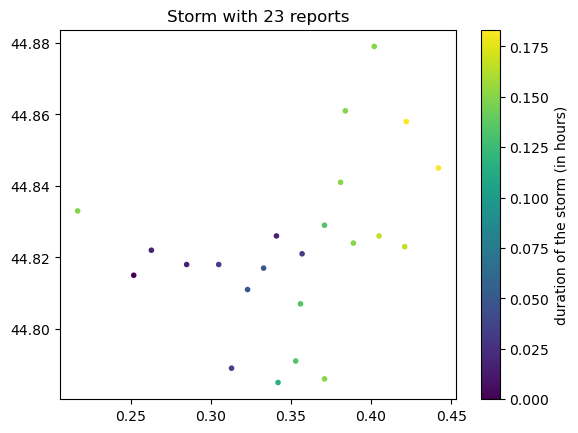

The storm has length 15.390550784301073 km between first report and last report
Spatial threshold is 0.09999999999999999


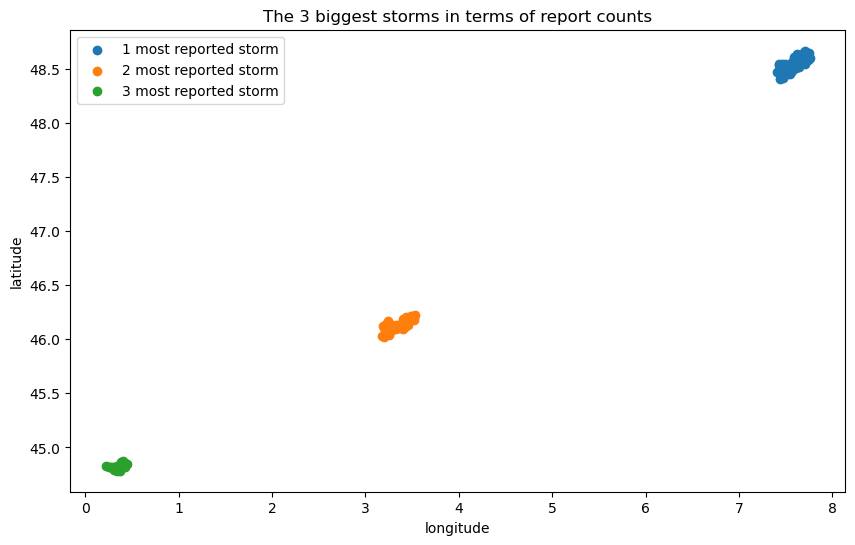

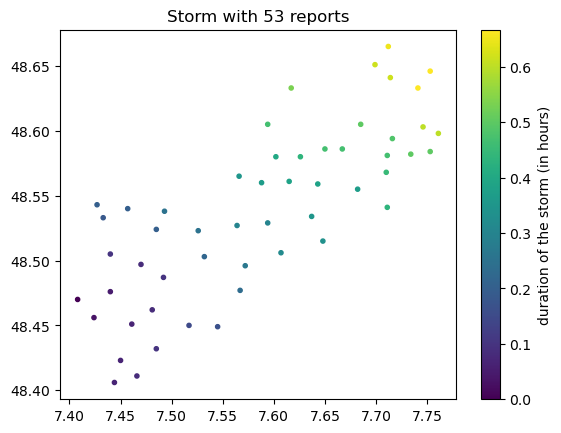

The storm has length 30.543821465197105 km between first report and last report


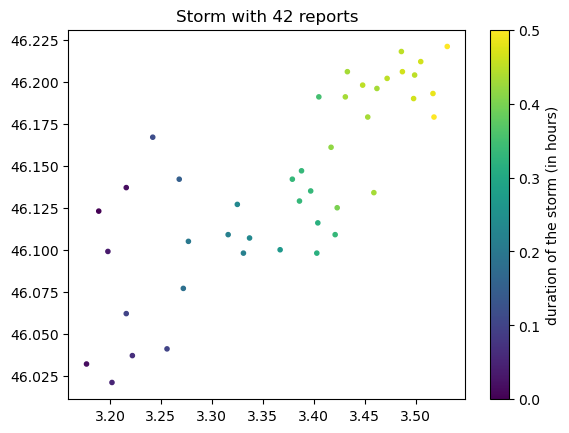

The storm has length 26.167127242818413 km between first report and last report


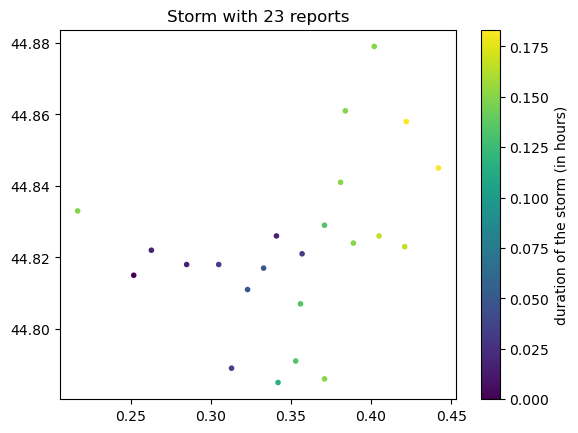

The storm has length 15.390550784301073 km between first report and last report
Spatial threshold is 0.13


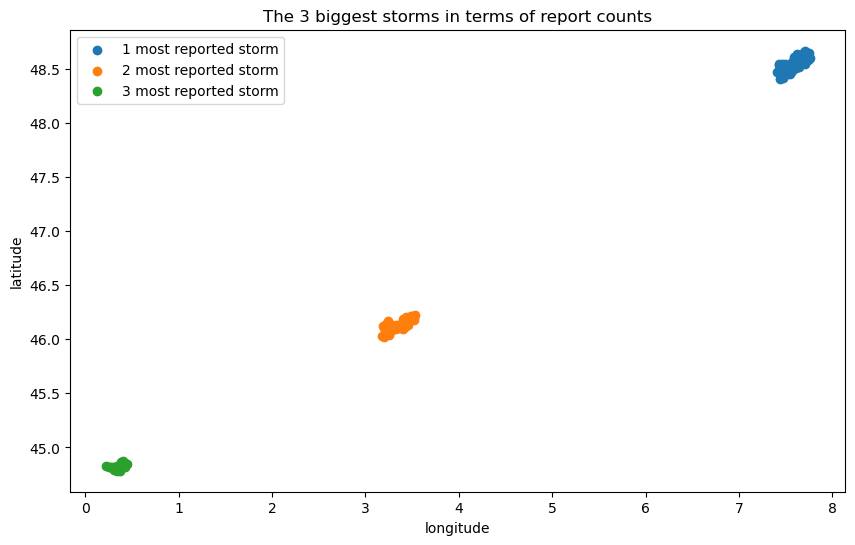

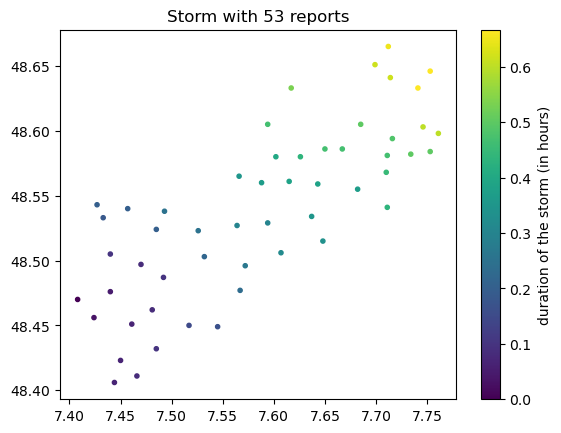

The storm has length 30.543821465197105 km between first report and last report


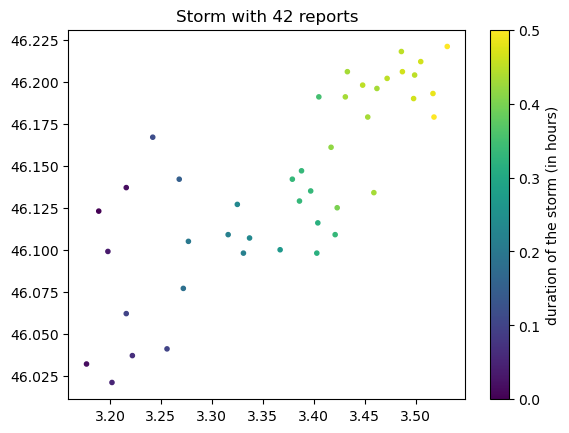

The storm has length 26.167127242818413 km between first report and last report


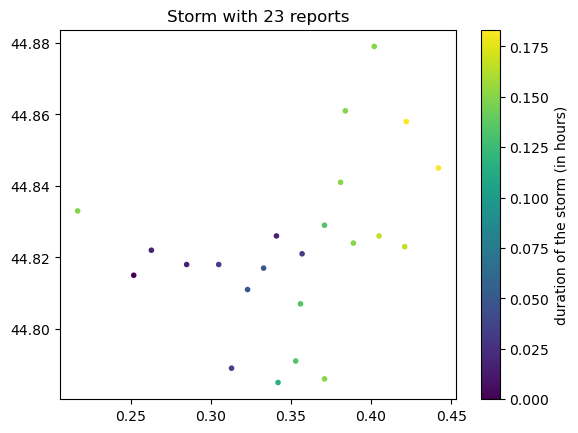

The storm has length 15.390550784301073 km between first report and last report
Spatial threshold is 0.16


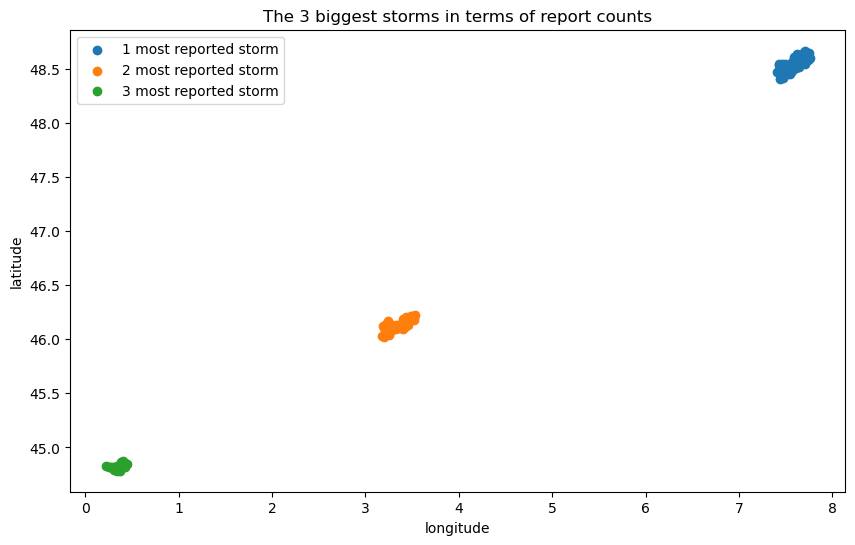

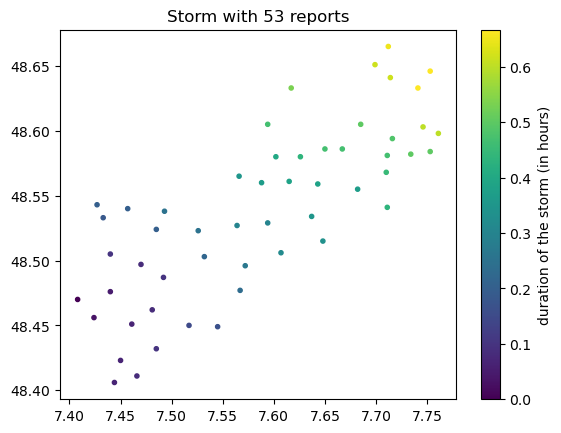

The storm has length 30.543821465197105 km between first report and last report


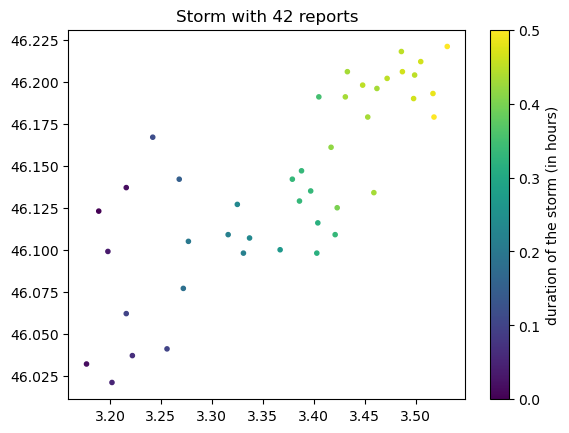

The storm has length 26.167127242818413 km between first report and last report


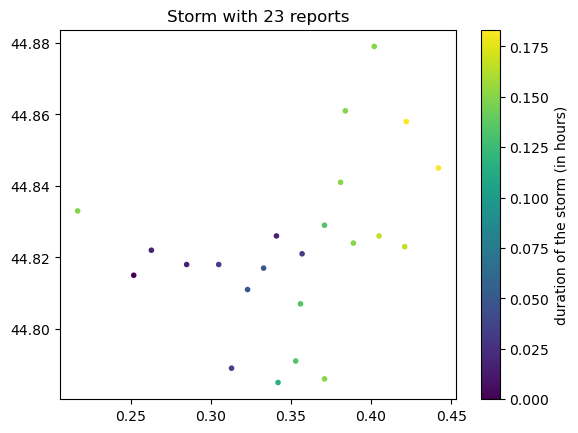

The storm has length 15.390550784301073 km between first report and last report
Spatial threshold is 0.19


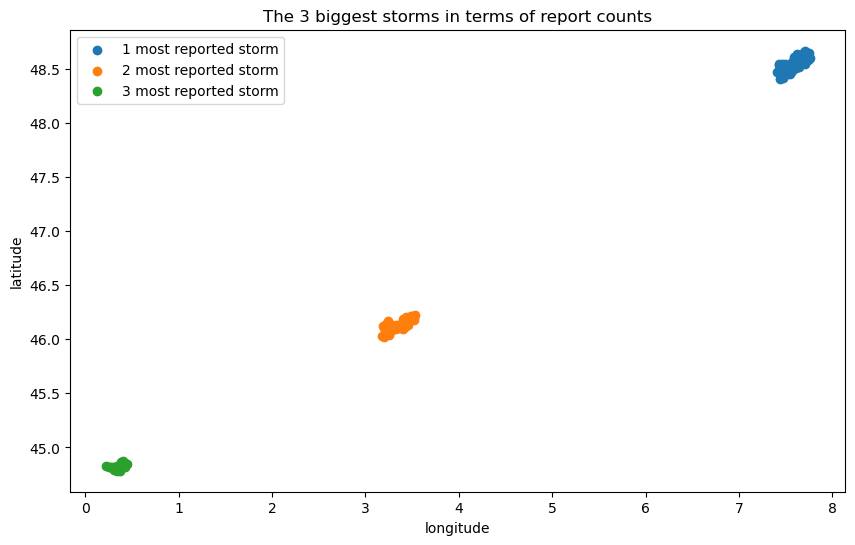

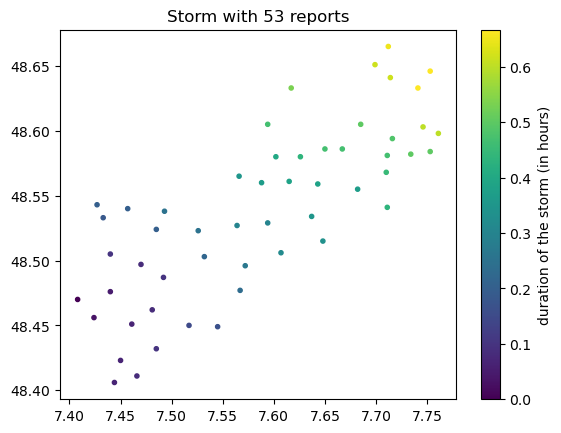

The storm has length 30.543821465197105 km between first report and last report


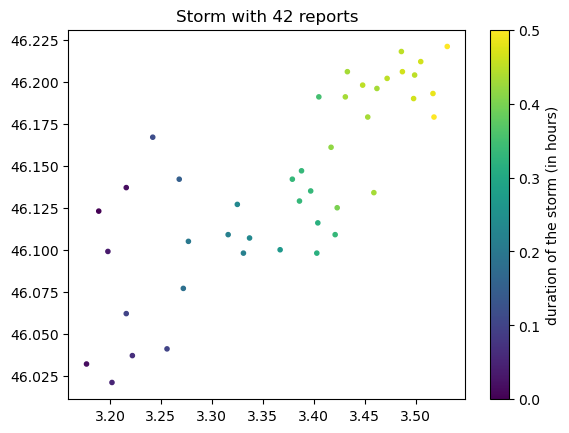

The storm has length 26.167127242818413 km between first report and last report


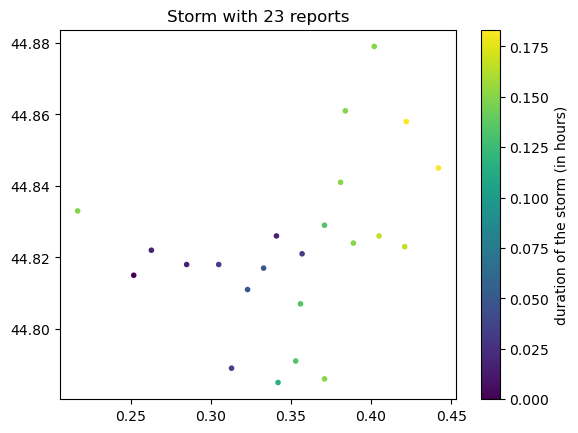

The storm has length 15.390550784301073 km between first report and last report
Spatial threshold is 0.22


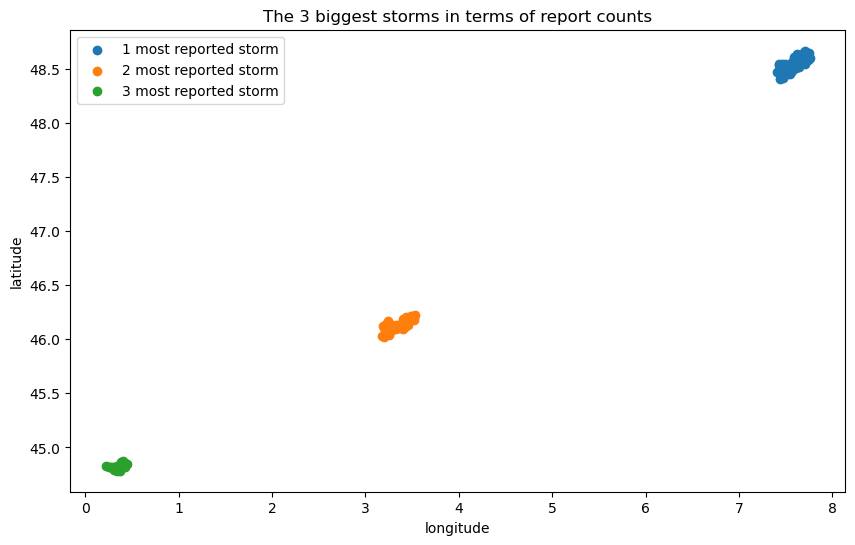

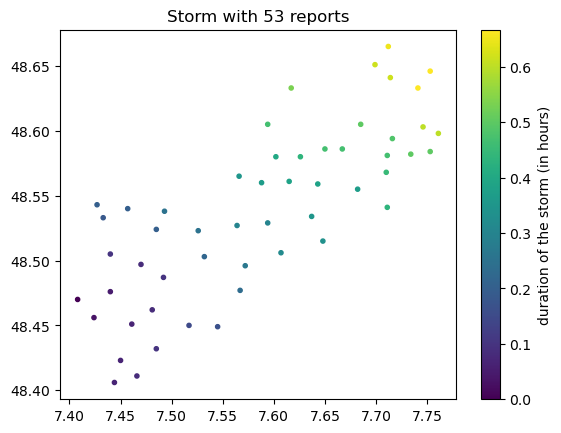

The storm has length 30.543821465197105 km between first report and last report


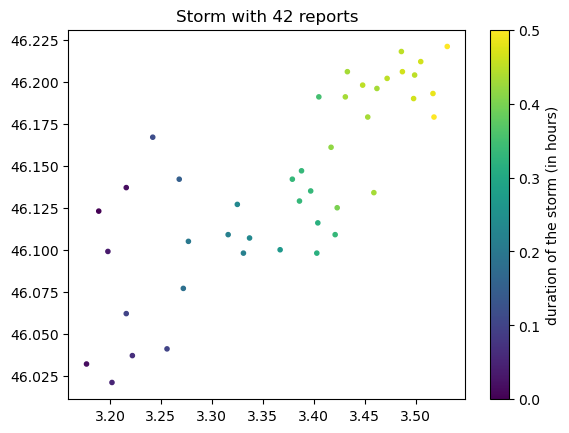

The storm has length 26.167127242818413 km between first report and last report


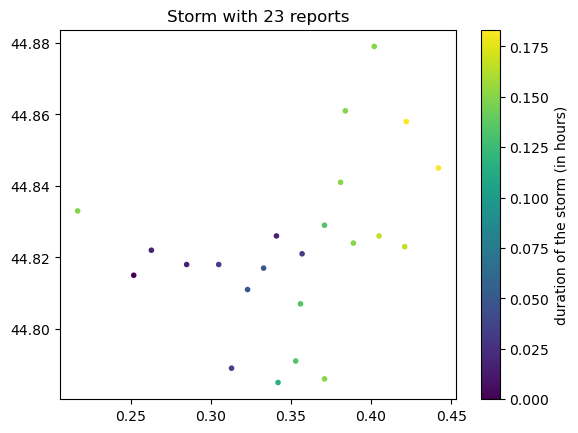

The storm has length 15.390550784301073 km between first report and last report
Spatial threshold is 0.25


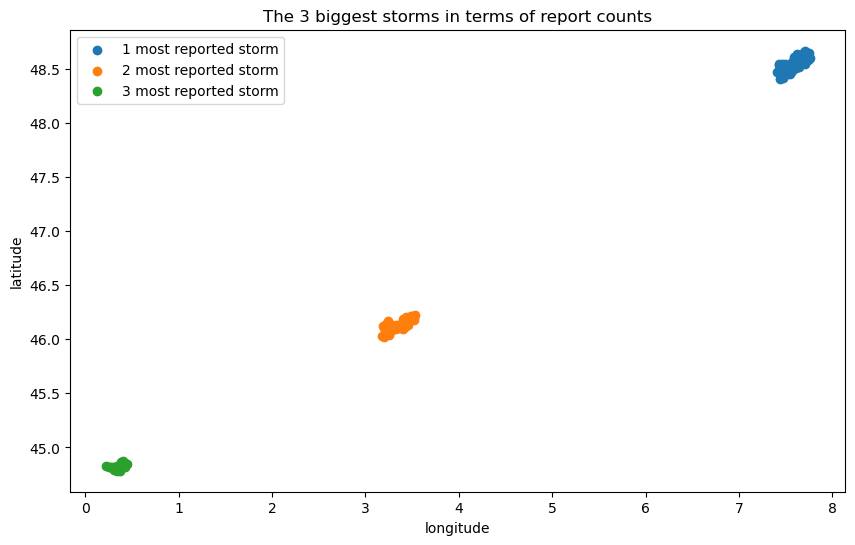

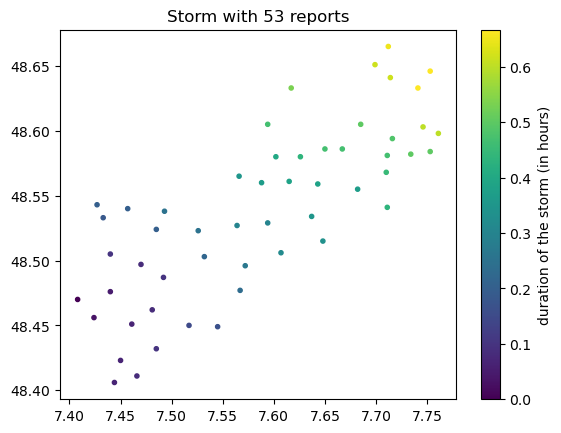

The storm has length 30.543821465197105 km between first report and last report


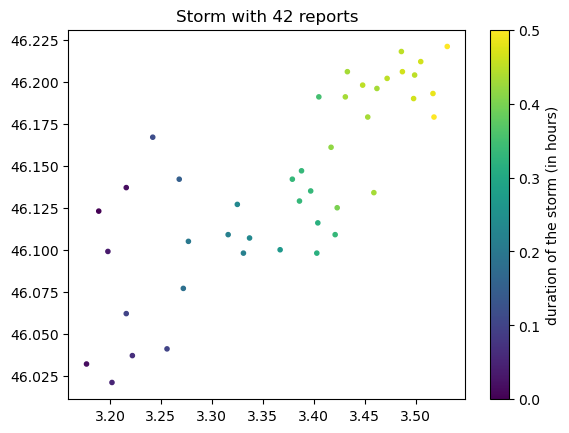

The storm has length 26.167127242818413 km between first report and last report


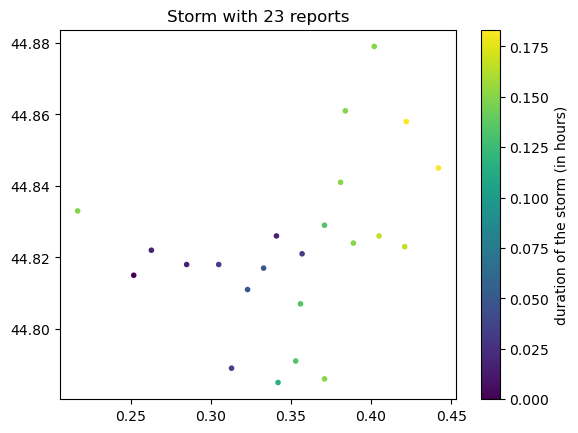

The storm has length 15.390550784301073 km between first report and last report
Spatial threshold is 0.28


In [178]:
#varying spatial threshold
for i in np.arange(0.01,0.3,0.03):
    visualise_biggest(run_dbscan_retrieve_classes(df, i, 2, 2),3)
    print("Spatial threshold is",i)

Explore bin cluster (percentage of reports we manage to cluster)

Run DBSCAN over since 2013 and compare the result